In [1]:
# imports
import json
import matplotlib.pyplot as plt
import numpy as np
import cmdstanpy as cs
import arviz as az
from scipy.stats import truncnorm, norm, halfnorm, invgamma, gamma, beta, halfcauchy
from tabulate import tabulate
from sklearn.neighbors import KernelDensity
from scipy.stats import norm, halfcauchy, gamma
import seaborn as sns
import math
import pandas as pd

In [2]:
fe_df = pd.read_csv('fe_model_data/fe_sand_model_data.csv', index_col=0)
fe_df.head()

,gamma,phi,k,wn
0,18,36,5000,0.13986
1,18,36,7000,0.14104
2,18,36,9000,0.14187
3,18,36,11000,0.14251
4,18,36,13000,0.14301


### Load fe data points and model them with a surrogate model

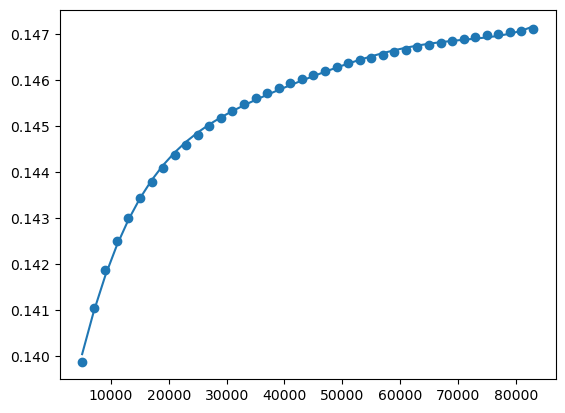

In [5]:
# # load surrogate/FE generated data points
# s_surr = np.genfromtxt(r'C:\Users\mes22ss\Ansys\PythonScripts\foundation_modelling\model_characterisation\x_true_model_characterisation.csv', delimiter=',')
# wn_surr = np.genfromtxt(r'C:\Users\mes22ss\Ansys\PythonScripts\foundation_modelling\model_characterisation\y_true_model_characterisation.csv', delimiter=',')

# s_surr_mean = np.mean(s_surr)
# wn_surr_mean = np.mean(wn_surr)
# s_surr_std = np.std(s_surr)
# wn_surr_std = np.std(wn_surr)

# Get surrogate model coefficients
coefficients = np.polyfit(fe_df.k, fe_df.wn, 5)

def surrogate(x):
    y = np.empty([np.size(x), 1]) # empty array
    y = coefficients[0]*(x ** 5) + coefficients[1]*(x ** 4) + coefficients[2]*(x ** 3) + coefficients[3]*(x ** 2) + coefficients[4]*(x ** 1) + coefficients[5]
    return y

plt.scatter(fe_df.k, fe_df.wn)
plt.plot(fe_df.k, np.polyval(coefficients, fe_df.k))

### Generate stiffness / nat freq data

Text(0, 0.5, 'Natural frequency (Hz)')

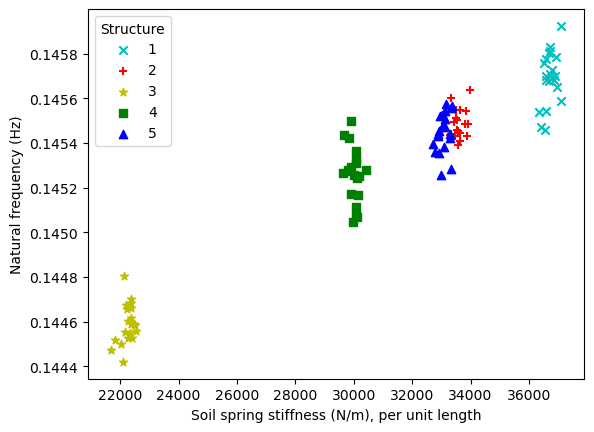

In [6]:
#np.random.seed(100) # for reproducability
np.random.seed(10) # playing around

# Define *True* global parameters
K = 5 # number of balanced class turbines
Nk = 20 # Number of observations per turbine
# Eloc = 3e4
# Escale = 5e3 # (this is standard deviation not variance)
# Vloc = 2e2
# Vscale = 2e1 # (this is standard deviation not variance)
# gamma_true = 0.0001

Emu = 3e4
Vmu = 5e3 # (this is standard deviation not variance)
Esig = 2e2
Vsig = 2e1 # (this is standard deviation not variance)
true_gamma = 0.0001

# adding imbalanced classes
imb_K = 0 # number of imbalanced class turbines
Nimb = 2 # number of observations per imbalanced turbine

# Draw turbine level expectation and variance parameters
mu_k = norm.rvs(loc=Emu, scale=Vmu, size=(K + imb_K,))
sig_k = norm.rvs(loc=Esig, scale=Vsig, size=(K + imb_K,))

# list of associated turbines for each observation
I = []
for i in range(K):
    I = np.append(I,(i+1)*np.ones(Nk)) 

wn = [] # natural frequency list
s = [] # foundation stiffness list

# wn measurement noise - Is this right? Every measurement should be unique I think
#noise = gamma_true*norm.rvs(loc=0, scale=1, size = Nk) # old
noise = true_gamma*norm.rvs(loc=0, scale=1, size = K*Nk) # new

for k in range(K):
# for k in range(K-2):
    ks = norm.rvs(loc=mu_k[k], scale=sig_k[k], size=Nk) # draw stiffness values for each turbine
    kwn = surrogate(ks) # compute natural frequency
    #wn = np.append(wn, wnk + noise) # old - add associated noise to each natural frequency
    wn = np.append(wn, kwn + noise[I==(k+1)]) # new
    s = np.append(s, ks) # store stiffness values

# # imbalanced turbines
if imb_K != 0:
    for k in range(imb_K):
        I = np.append(I,(k+K+1)*np.ones(Nimb)) # update list of turbines
        noise = np.append(noise, true_gamma*norm.rvs(loc=0, scale=1, size=Nimb)) 
        ks = norm.rvs(loc=mu_k[K+k], scale=sig_k[K+k], size=Nimb)
        wnk = surrogate(ks)
        wn = np.append(wn, wnk + noise[I==(K+k+1)])
        s = np.append(s, ks)

# plt.figure()
# plt.scatter(s,wn)
# plt.plot(s_surr, np.poly1d(coefficients)(s_surr), c='r')
# #plt.scatter(s_surr,wn_surr, c='c')

plt.figure()
colors = ["c", "r", "y", "g", "b", "k"]*10000
marks = ["x", "+", "*", "s", "^", "v", ".", "o", "<", "<"]*10000
labels = ["1", "2", "3", "4", "5"]*10000
#plt.scatter(s[0:Nk],wn[0:Nk],color=colors[0])

for k in range(K):
    #plt.scatter(s[(k+1)*Nk+k:(k+2)*Nk],wn_calc[(k+1)*Nk+k:(k+2)*Nk],color=colors[k+1])
    plt.scatter(s[k*Nk:(k+1)*Nk],wn[k*Nk:(k+1)*Nk],color=colors[k], marker=marks[k], label=labels[k])
for k in range(imb_K):
    plt.scatter(s[I==K+k+1],wn[I==K+k+1],color=colors[k+K], marker=marks[k+K], label=str(K+k+1))

plt.legend(title="Structure")
plt.xlabel('Soil spring stiffness (N/m), per unit length')
plt.ylabel('Natural frequency (Hz)')

# # imbalanced
# for k in range(K-2):
#     #plt.scatter(s[(k+1)*Nk+k:(k+2)*Nk],wn_calc[(k+1)*Nk+k:(k+2)*Nk],color=colors[k+1])
#     plt.scatter(s[k*Nk:(k+1)*Nk],wn_calc[k*Nk:(k+1)*Nk],color=colors[k])
# plt.scatter(s[500:510],wn_calc[500:510],color="k")
# plt.scatter(s[510:515],wn_calc[510:515], s=200)




### Check generated data roughly matches chosen parameters

In [7]:
def weighted_avg_and_std(values, weights):
    """
    Return the weighted average and standard deviation.

    They weights are in effect first normalized so that they 
    sum to 1 (and so they must not all be 0).

    values, weights -- NumPy ndarrays with the same shape.
    """
    average = np.average(values, weights=weights)
    # Fast and numerically precise:
    variance = np.average((values-average)**2, weights=weights)
    return (average, math.sqrt(variance))

weights = []
for k in range(K):
    weights = np.append(weights, Nk)
for k in range(imb_K):
    weights = np.append(weights, Nimb)

stds = []
for k in range(K + imb_K):
    stds = np.append(stds, np.std(s[I==k+1]))

gen_Emu = np.mean(s)
gen_Vmu = np.std(s)
gen_Esig, gen_Vsig = weighted_avg_and_std(stds, weights)
gen_gamma = np.std(wn - np.poly1d(coefficients)(s))

print("generated data")
print("Emu: " + str(gen_Emu) + " / " + str(Emu))
print("Vmu: " + str(gen_Vmu) + " / " + str(Vmu))
print("Esig: " + str(gen_Esig) + " / " + str(Esig))
print("Vsig: " + str(gen_Vsig) + " / " + str(Vsig))
print("gamma: " + str(gen_gamma) + " / " + str(true_gamma))


generated data
Emu: 31124.162094776166 / 30000.0
Vmu: 4926.460698100338 / 5000.0
Esig: 196.06423786057684 / 200.0
Vsig: 13.41392067380718 / 20.0
gamma: 9.748643529095864e-05 / 0.0001


### untransformed priors

<function matplotlib.pyplot.tight_layout(*, pad: 'float' = 1.08, h_pad: 'float | None' = None, w_pad: 'float | None' = None, rect: 'tuple[float, float, float, float] | None' = None) -> 'None'>

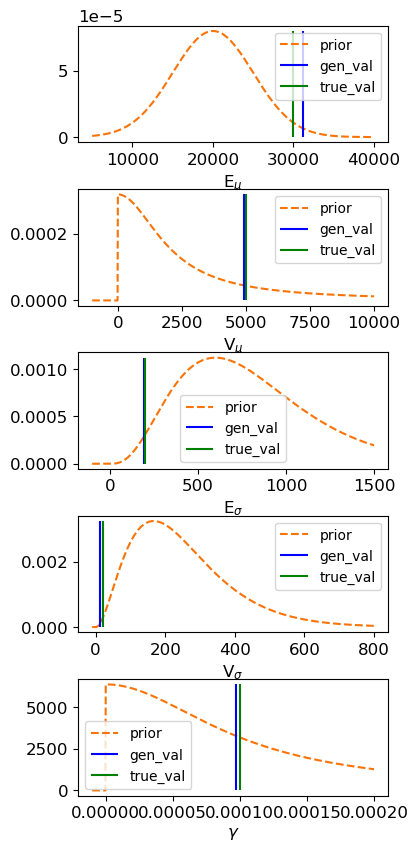

In [30]:
# # true values
# Emu = 3e4
# Vmu = 5e3 # (this is standard deviation not variance)
# Esig = 2e2
# Vsig = 2e1 # (this is standard deviation not variance)
# gamma = 0.0001


### define priors

# ----- untransformed priors -----
# Emu0 = [23e6, 3e6] #2e7
# Vmu0 = [15e5, 5e5] #2e6 
# Esig0 = [3e5, 1e5] #2e5 
# Vsig0 = [25e3, 1e4] #2e4 
# sigma0 = [0, 0.1]

Emu0 = [20e3, 5e3] # normal
Vmu0 = [0, 2e3] # halfcauchy
#Vmu0 = [0.5, 25e-8] # gamma
#Esig0 = [3e5, 1e5] # normal
#Esig0 = [27, 9e-5] # gamma
Esig0 = [4, 5e-3] # gamma
#Esig0 = [0, 800] # halfcauchy
#Esig0 = [200, 5e-4] # gamma
#Vsig0 = [0, 3e4] # halfcauchy
Vsig0 = [3, 12e-3] # gamma
#Vsig0 = [0, 25] # halfcauchy
#gamma0 = [1, 10000] # gamma
true_gamma0 = [0, 1e-4] # halfcauchy


#priors for plotting
#plt.figure()
Emu_x = np.linspace(5e3, 40e3, 1000)
Emu_y = norm.pdf(Emu_x, Emu0[0], Emu0[1])
Vmu_x = np.linspace(-1e3, 1e4, 1000)
#Vmu_y = gamma.pdf(Vmu_x, a=Vmu0[0], scale=1/Vmu0[1])
Vmu_y = halfcauchy.pdf(Vmu_x, Vmu0[0], Vmu0[1])
Esig_x = np.linspace(-1e2, 15e2, 1000)
#Esig_y = norm.pdf(Esig_x, Esig0[0], Esig0[1])
Esig_y = gamma.pdf(Esig_x, a=Esig0[0], scale=1/Esig0[1])
#Esig_y = halfcauchy.pdf(Esig_x, Esig0[0], Esig0[1])
Vsig_x = np.linspace(-1e1, 8e2, 1000)
#Vsig_y = halfcauchy.pdf(Vsig_x, Vsig0[0], Vsig0[1])
Vsig_y = gamma.pdf(Vsig_x, a=Vsig0[0], scale=1/Vsig0[1])
#Vsig_y = halfcauchy.pdf(Vsig_x, Vsig0[0], Vsig0[1])

gamma_x = np.linspace(-1e-5, 2e-4, 1000)
#gamma_y = gamma.pdf(gamma_x, a=gamma0[0], scale=1/gamma0[1])
gamma_y = halfcauchy.pdf(gamma_x, true_gamma0[0], true_gamma0[1])


# plots

plt.rcParams.update({'font.size': 12})
fig, ax = plt.subplots(5,1,figsize=(4,10))
fig.subplots_adjust(hspace=0.4) # adjust subplot spacing

plt.subplot(5,1,1)
plt.plot(Emu_x, Emu_y, color="#F97306", linestyle="--", label="prior")
plt.vlines(x=gen_Emu, ymin=0, ymax=np.max(Emu_y), label="gen_val", colors="b")
plt.vlines(x=Emu, ymin=0, ymax=np.max(Emu_y), label="true_val", colors="g")
plt.xlabel('E$_\mu$')
plt.legend(fontsize=10)

plt.subplot(5,1,2)
plt.plot(Vmu_x, Vmu_y, color="#F97306", linestyle="--", label="prior")
plt.vlines(x=gen_Vmu, ymin=0, ymax=np.max(Vmu_y), label="gen_val", colors="b")
plt.vlines(x=Vmu, ymin=0, ymax=np.max(Vmu_y), label="true_val", colors="g")
plt.xlabel('V$_\mu$')
plt.legend(fontsize=10)

plt.subplot(5,1,3)
plt.plot(Esig_x, Esig_y, color="#F97306", linestyle="--", label="prior")
plt.vlines(x=gen_Esig, ymin=0, ymax=np.max(Esig_y), label="gen_val", colors="b")
plt.vlines(x=Esig, ymin=0, ymax=np.max(Esig_y), label="true_val", colors="g")
plt.xlabel('E$_\sigma$')
plt.legend(fontsize=10)

plt.subplot(5,1,4)
plt.plot(Vsig_x, Vsig_y, color="#F97306", linestyle="--", label="prior")
plt.vlines(x=gen_Vsig, ymin=0, ymax=np.max(Vsig_y), label="gen_val", colors="b")
plt.vlines(x=Vsig, ymin=0, ymax=np.max(Vsig_y), label="true_val", colors="g")
plt.xlabel('V$_\sigma$')
plt.legend(fontsize=10)

plt.subplot(5,1,5)
plt.plot(gamma_x, gamma_y, color="#F97306", linestyle="--", label="prior")
plt.vlines(x=gen_gamma, ymin=0, ymax=np.max(gamma_y), label="gen_val", colors="b")
plt.vlines(x=true_gamma, ymin=0, ymax=np.max(gamma_y), label="true_val", colors="g")
plt.xlabel('$\gamma$')
plt.legend(fontsize=10)

plt.tight_layout



### transformed priors

In [ ]:

# ----- transformed priors -----
# z- transformed versions
# z_Emu0 = [3, 2] # normal
# z_Vmu0 = [0, 0.5] # halfcauchy
# #z_Vmu0 = [1, 1] # gamma
# z_Esig0 = [1, 1] # gamma
# z_Vsig0 = [1, 1] # gamma
# #z_gamma0 = [1, 1] # gamma
# # z_Vmu0 = [0, 0.5] # halfcauchy
# # z_Esig0 = [0, 0.5] # halfcauchy
# # z_Vsig0 = [0, 0.5] # halfcauchy
# z_gamma0 = [0, 0.5] # halfcauchy

# mean removed versions
z_Emu0 = [1e6, 2e6] # normal
z_Vmu0 = [0, 2e6] # halfcauchy
z_Esig0 = [27, 9e-5] # gamma
z_Vsig0 = [8, 3e-4] # gamma
z_gamma0 = [0, 2e-4] # halfcauchy

# z-transformed
plt.figure()
# z_Emu_x = np.linspace(-8, 8, 100)
# z_Emu_y = norm.pdf(z_Emu_x, z_Emu0[0], z_Emu0[1])
# z_Vmu_x = np.linspace(-8, 8, 100)
# z_Vmu_y = halfcauchy.pdf(z_Vmu_x, z_Vmu0[0], z_Vmu0[1])
# #z_Vmu_y = gamma.pdf(z_Vmu_x, a=z_Vmu0[0], scale=1/z_Vmu0[1])

# z_Esig_x = np.linspace(-8, 8, 100)
# z_Esig_y = gamma.pdf(z_Esig_x, a=z_Esig0[0], scale=1/z_Esig0[1])
# #z_Esig_y = halfcauchy.pdf(z_Esig_x, z_Esig0[0], z_Esig0[1])
# z_Vsig_x = np.linspace(-8, 8, 100)
# z_Vsig_y = gamma.pdf(z_Vsig_x, a=z_Vsig0[0], scale=1/z_Vsig0[1])
# #z_Vsig_y = halfcauchy.pdf(z_Vsig_x, z_Vsig0[0], z_Vsig0[1])

# z_gamma_x = np.linspace(-0.0002, 1, 100)
# #z_gamma_y = gamma.pdf(z_gamma_x, a=z_gamma0[0], scale=1/z_gamma0[1])
# z_gamma_y = halfcauchy.pdf(z_gamma_x, z_gamma0[0], z_gamma0[1])

# mean removed only
z_Emu_x = np.linspace(-3e6, 3e7, 100)
z_Emu_y = norm.pdf(z_Emu_x, z_Emu0[0], z_Emu0[1])
z_Vmu_x = np.linspace(-2e6, 6e6, 100)
z_Vmu_y = halfcauchy.pdf(z_Vmu_x, z_Vmu0[0], z_Vmu0[1])
#z_Vmu_y = gamma.pdf(z_Vmu_x, a=z_Vmu0[0], scale=1/z_Vmu0[1])

z_Esig_x = np.linspace(-2e5, 1e6, 100)
z_Esig_y = gamma.pdf(z_Esig_x, a=z_Esig0[0], scale=1/z_Esig0[1])
#z_Esig_y = halfcauchy.pdf(z_Esig_x, z_Esig0[0], z_Esig0[1])
z_Vsig_x = np.linspace(-2e4, 1e5, 100)
z_Vsig_y = gamma.pdf(z_Vsig_x, a=z_Vsig0[0], scale=1/z_Vsig0[1])
#z_Vsig_y = halfcauchy.pdf(z_Vsig_x, z_Vsig0[0], z_Vsig0[1])

z_gamma_x = np.linspace(-0.0002, 0.01, 100)
#z_gamma_y = gamma.pdf(z_gamma_x, a=z_gamma0[0], scale=1/z_gamma0[1])
z_gamma_y = halfcauchy.pdf(z_gamma_x, z_gamma0[0], z_gamma0[1])

plt.rcParams.update({'font.size': 12})
fig, ax = plt.subplots(5,1,figsize=(4,10))
fig.subplots_adjust(hspace=0.4) # adjust subplot spacing

plt.subplot(5,1,1)
plt.plot(z_Emu_x, z_Emu_y, color="#F97306", linestyle="--", label="prior")
plt.xlabel('z_E$_\mu$')
plt.legend(fontsize=10)

plt.subplot(5,1,2)
plt.plot(z_Vmu_x, z_Vmu_y, color="#F97306", linestyle="--", label="prior")
plt.xlabel('z_V$_\mu$')
plt.legend(fontsize=10)

plt.subplot(5,1,3)
plt.plot(z_Esig_x, z_Esig_y, color="#F97306", linestyle="--", label="prior")
plt.xlabel('z_E$_\sigma$')
plt.legend(fontsize=10)

plt.subplot(5,1,4)
plt.plot(z_Vsig_x, z_Vsig_y, color="#F97306", linestyle="--", label="prior")
plt.xlabel('z_V$_\sigma$')
plt.legend(fontsize=10)

plt.subplot(5,1,5)
plt.plot(z_gamma_x, z_gamma_y, color="#F97306", linestyle="--", label="prior")
plt.xlabel('z_$\gamma$')
plt.legend(fontsize=10)
plt.tight_layout


### Partial pooling model

In [9]:
### partial-pooling model

# # imbalanced bit
# I = np.append(I,5*np.ones(10))
# I = np.append(I,6*np.ones(5))

# print(I)

data = {
    "N": len(I),
    "K": K + imb_K,
    "c": coefficients,
    "I": I.astype(int),
    "wn": wn,
    "Emu0": Emu0,
    "Esig0": Esig0,
    "Vmu0": Vmu0,
    "Vsig0": Vsig0,
    "gamma0": true_gamma0,
}

#PP = cs.CmdStanModel(stan_file='hierarchical_model.stan')
PP = cs.CmdStanModel(stan_file='hierarchical_model_v2.stan')

ssPP = PP.sample(data, iter_warmup=1000, iter_sampling=1000, adapt_delta=.999,
                    max_treedepth=20, )
# #ssPP = PP.sample(data, iter_warmup=500, iter_sampling=1000, adapt_delta=.98,
#                    max_treedepth=20, )

azPP = az.InferenceData(posterior=ssPP.draws_xr())

14:35:30 - cmdstanpy - INFO - compiling stan file C:\Users\mes22ss\AppData\Local\Temp\tmprw7baqdj\tmpaq9rywuw.stan to exe file G:\My Drive\Python\hierarchical_foundations\hierarchical_model_v2.exe
14:35:52 - cmdstanpy - INFO - compiled model executable: G:\My Drive\Python\hierarchical_foundations\hierarchical_model_v2.exe
14:35:53 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

14:36:24 - cmdstanpy - INFO - CmdStan done processing.
14:36:24 - cmdstanpy - WARNING - Non-fatal error during sampling:
Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in 'C:/Users/mes22ss/AppData/Local/Temp/tmprw7baqdj/tmpaq9rywuw.stan', line 66, column 4 to column 28)
Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in 'C:/Users/mes22ss/AppData/Local/Temp/tmprw7baqdj/tmpaq9rywuw.stan', line 66, column 4 to column 28)
Consider re-running with show_console=True if the above output is unclear!


In [10]:
print(ssPP.diagnose())


Processing csv files: C:\Users\mes22ss\AppData\Local\Temp\tmpvb5tf5ea\hierarchical_model_v2m5xum1bq\hierarchical_model_v2-20240229143553_1.csv, C:\Users\mes22ss\AppData\Local\Temp\tmpvb5tf5ea\hierarchical_model_v2m5xum1bq\hierarchical_model_v2-20240229143553_2.csv, C:\Users\mes22ss\AppData\Local\Temp\tmpvb5tf5ea\hierarchical_model_v2m5xum1bq\hierarchical_model_v2-20240229143553_3.csv, C:\Users\mes22ss\AppData\Local\Temp\tmpvb5tf5ea\hierarchical_model_v2m5xum1bq\hierarchical_model_v2-20240229143553_4.csv

Checking sampler transitions treedepth.
Treedepth satisfactory for all transitions.

Checking sampler transitions for divergences.
No divergent transitions found.

Checking E-BFMI - sampler transitions HMC potential energy.
The E-BFMI, 0.10, is below the nominal threshold of 0.30 which suggests that HMC may have trouble exploring the target distribution.
If possible, try to reparameterize the model.

Effective sample size satisfactory.

The following parameters had split R-hat greater 

### get inferred/learned values

In [11]:
# posteriors
posterior_Emu = azPP.posterior.Emu
posterior_Vmu = azPP.posterior.Vmu

posterior_Esig = azPP.posterior.Esig
posterior_Vsig = azPP.posterior.Vsig

posterior_Es = azPP.posterior.Es
posterior_Vs = azPP.posterior.Vs
posterior_gamma = azPP.posterior.gamma

posterior_s = azPP.posterior.s

In [84]:
azPP

Inference data with groups:
	> posterior

### plot the chains

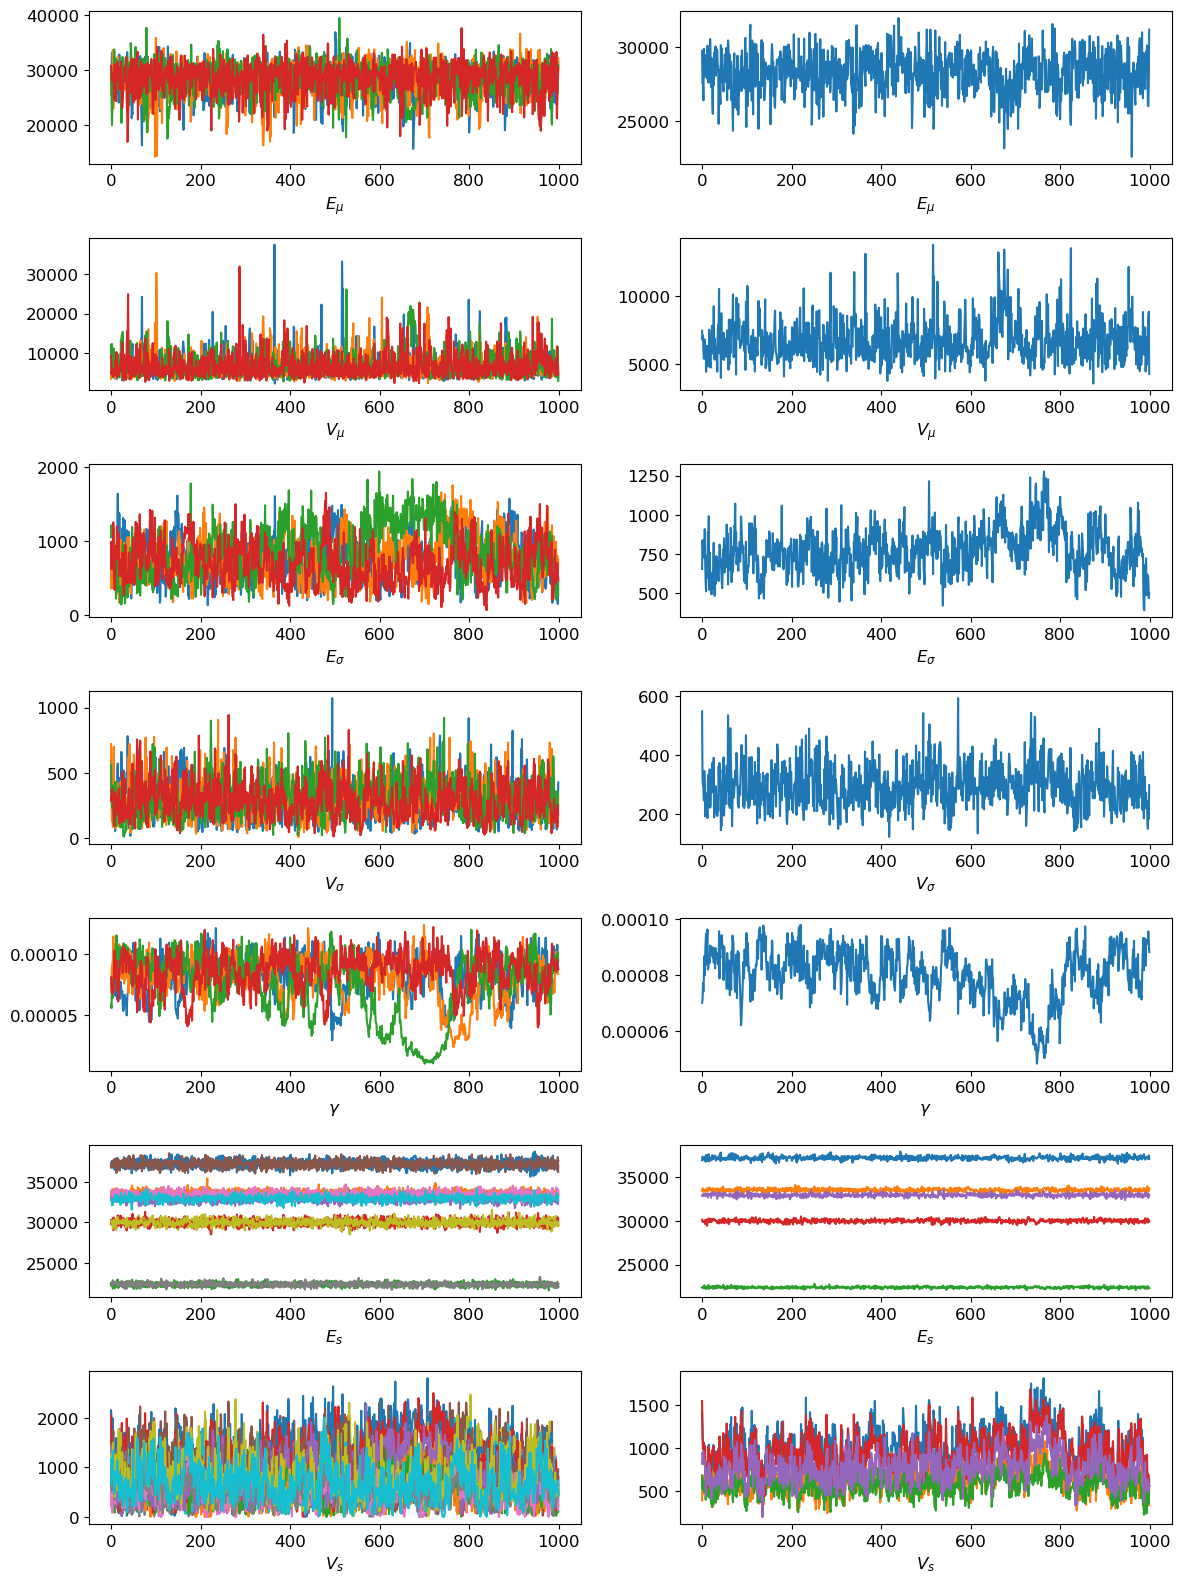

In [12]:

fig, ax = plt.subplots(7,2,figsize=(12,16))

# per chain
for i in range(4):
    plt.subplot(7,2,1)
    plt.plot(posterior_Emu[i,:])
    plt.xlabel('$E_\mu$')
    plt.subplot(7,2,3)
    plt.plot(posterior_Vmu[i,:])
    plt.xlabel('$V_\mu$')
    plt.subplot(7,2,5)
    plt.plot(posterior_Esig[i,:])
    plt.xlabel('$E_\sigma$')
    plt.subplot(7,2,7)
    plt.plot(posterior_Vsig[i,:])
    plt.xlabel('$V_\sigma$')
    plt.subplot(7,2,9)
    plt.plot(posterior_gamma[i,:])
    plt.xlabel('$\gamma$')

for i in range(4):
    for j in range(K):
        plt.subplot(7,2,11)
        plt.plot(posterior_Es[i,:,j])
        plt.xlabel('$E{_s}$')
        plt.subplot(7,2,13)
        plt.plot(posterior_Vs[i,:,j])
        plt.xlabel('$V{_s}$')

# chain averages

plt.subplot(7,2,2)
plt.plot(np.mean(posterior_Emu,axis=0))
plt.xlabel('$E_\mu$')
plt.subplot(7,2,4)
plt.plot(np.mean(posterior_Vmu,axis=0))
plt.xlabel('$V_\mu$')
plt.subplot(7,2,6)
plt.plot(np.mean(posterior_Esig,axis=0))
plt.xlabel('$E_\sigma$')
plt.subplot(7,2,8)
plt.plot(np.mean(posterior_Vsig,axis=0))
plt.xlabel('$V_\sigma$')
plt.subplot(7,2,10)
plt.plot(np.mean(posterior_gamma,axis=0))
plt.xlabel('$\gamma$')

for j in range(K):
    plt.subplot(7,2,12)
    plt.plot(np.mean(posterior_Es,axis=0)[:,j])
    plt.xlabel('$E{_s}$')
    plt.subplot(7,2,14)
    plt.plot(np.mean(posterior_Vs,axis=0)[:,j])
    plt.xlabel('$V{_s}$')


plt.tight_layout()

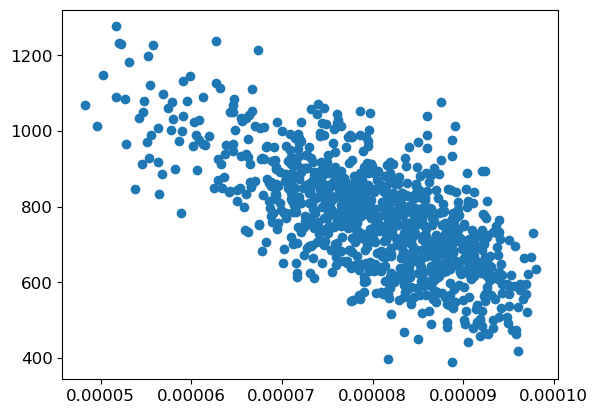

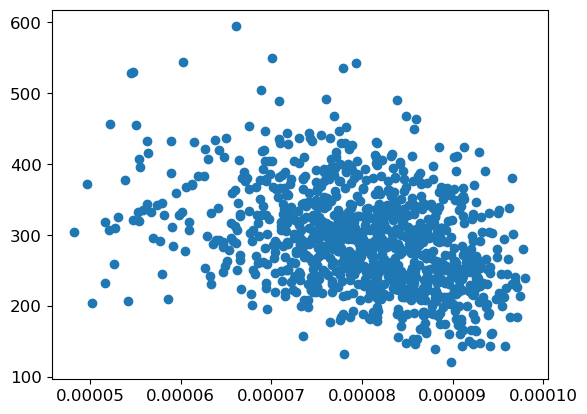

In [13]:
plt.figure()
plt.scatter(np.mean(posterior_gamma,axis=0),np.mean(posterior_Esig,axis=0))
plt.figure()
plt.scatter(np.mean(posterior_gamma,axis=0),np.mean(posterior_Vsig,axis=0))

### Untransformed model

C:\Users\mes22ss\AppData\Local\Temp\ipykernel_23816\2604356753.py:60: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(posterior_Emu[i,:], ax=ax[0,0], hist=False, color="#1D3557", kde_kws={'linestyle':linestyles[i], 'linewidth':0.75}, label="c"+str(i+1))
c:\Users\mes22ss\AppData\Local\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
C:\Users\mes22ss\AppData\Local\Temp\ipykernel_23816\2604356753.py:61: UserWarning: 

`distplot` is a depr

IndexError: Boolean array size 100 is used to index array with shape (4, 1000, 100).

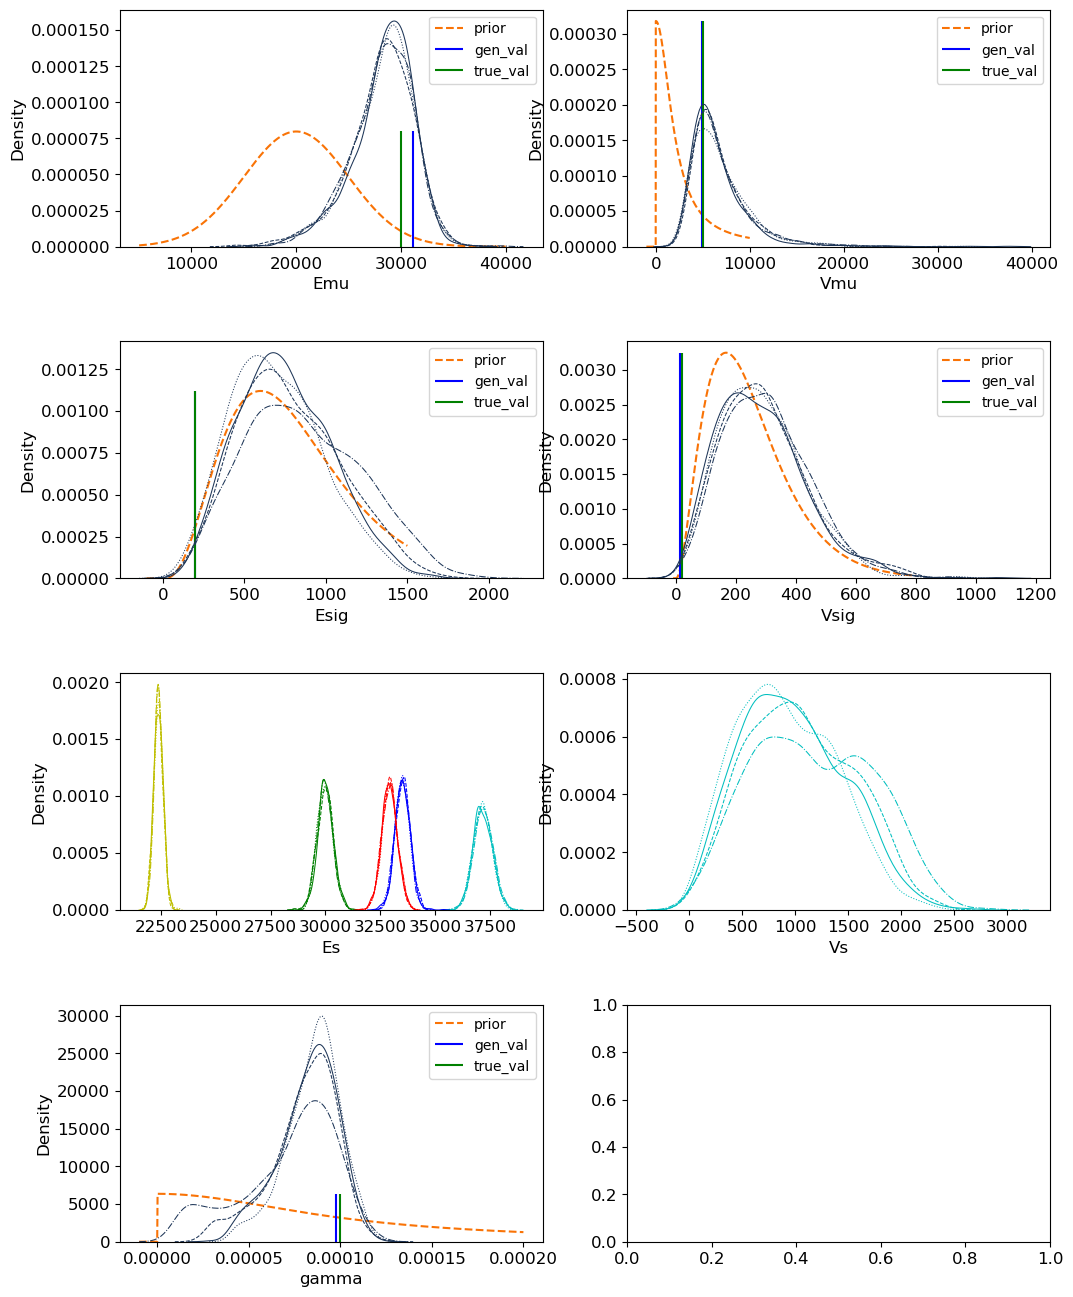

In [31]:
from scipy.stats import norm, halfcauchy
import seaborn as sns

plt.rcParams.update({'font.size': 12})

fig, ax = plt.subplots(4,2,figsize=(12,16))
fig.subplots_adjust(hspace=0.4) # adjust subplot spacing


# priors

plt.subplot(4,2,1)
plt.plot(Emu_x, Emu_y, color="#F97306", linestyle="--", label="prior")
plt.vlines(x=gen_Emu, ymin=0, ymax=np.max(Emu_y), label="gen_val", colors="b")
plt.vlines(x=Emu, ymin=0, ymax=np.max(Emu_y), label="true_val", colors="g")
plt.xlabel('E$_\mu$')
plt.legend(fontsize=10)

plt.subplot(4,2,2)
plt.plot(Vmu_x, Vmu_y, color="#F97306", linestyle="--", label="prior")
plt.vlines(x=gen_Vmu, ymin=0, ymax=np.max(Vmu_y), label="gen_val", colors="b")
plt.vlines(x=Vmu, ymin=0, ymax=np.max(Vmu_y), label="true_val", colors="g")
plt.xlabel('V$_\mu$')
plt.legend(fontsize=10)

plt.subplot(4,2,3)
plt.plot(Esig_x, Esig_y, color="#F97306", linestyle="--", label="prior")
plt.vlines(x=gen_Esig, ymin=0, ymax=np.max(Esig_y), label="gen_val", colors="b")
plt.vlines(x=Esig, ymin=0, ymax=np.max(Esig_y), label="true_val", colors="g")
plt.xlabel('E$_\sigma$')
plt.legend(fontsize=10)

plt.subplot(4,2,4)
plt.plot(Vsig_x, Vsig_y, color="#F97306", linestyle="--", label="prior")
plt.vlines(x=gen_Vsig, ymin=0, ymax=np.max(Vsig_y), label="gen_val", colors="b")
plt.vlines(x=Vsig, ymin=0, ymax=np.max(Vsig_y), label="true_val", colors="g")
plt.xlabel('V$_\sigma$')
plt.legend(fontsize=10)

plt.subplot(4,2,5)
plt.xlabel('$E_s$')

plt.subplot(4,2,6)
plt.xlabel('$V_s$')

plt.subplot(4,2,7)
plt.plot(gamma_x, gamma_y, color="#F97306", linestyle="--", label="prior")
plt.vlines(x=gen_gamma, ymin=0, ymax=np.max(gamma_y), label="gen_val", colors="b")
plt.vlines(x=true_gamma, ymin=0, ymax=np.max(gamma_y), label="true_val", colors="g")
plt.xlabel('$\gamma$')
plt.legend(fontsize=10)


linestyles = ['-', '--', '-.', ':']*4
colors = ["c", "b", "y", "g", "r", "k"]*16
labels = ["1", "2", "3", "4", "5"]*4

# global parameters
for i in range(4):
    sns.distplot(posterior_Emu[i,:], ax=ax[0,0], hist=False, color="#1D3557", kde_kws={'linestyle':linestyles[i], 'linewidth':0.75}, label="c"+str(i+1))
    sns.distplot(posterior_Vmu[i,:], ax=ax[0,1], hist=False, color="#1D3557", kde_kws={'linestyle':linestyles[i], 'linewidth':0.75}, label="c"+str(i+1))
    sns.distplot(posterior_Esig[i,:], ax=ax[1,0], hist=False, color='#1D3557', kde_kws={'linestyle':linestyles[i], 'linewidth':0.75}, label="c"+str(i+1))
    sns.distplot(posterior_Vsig[i,:], ax=ax[1,1], hist=False, color='#1D3557', kde_kws={'linestyle':linestyles[i], 'linewidth':0.75}, label="c"+str(i+1))
    sns.distplot(posterior_gamma[i,:], ax=ax[3,0], hist=False, color='#1D3557', kde_kws={'linestyle':linestyles[i], 'linewidth':0.75}, label="c"+str(i+1))

# turbine level parameters
for k in range(K + imb_K):
    for j in range(4):
        if j == 0:
            sns.distplot(posterior_Es[j,:,k], ax=ax[2,0], hist=False, color=colors[k], kde_kws={'linestyle':linestyles[j], 'linewidth':0.75}, label=str(k+1))
        else:
            sns.distplot(posterior_Es[j,:,k], ax=ax[2,0], hist=False, color=colors[k], kde_kws={'linestyle':linestyles[j], 'linewidth':0.75})

for k in range(K + imb_K):
    for j in range(4):
        if j == 0:
            sns.distplot(posterior_Vs[j,:,k], ax=ax[2,1], hist=False, color=colors[k], kde_kws={'linestyle':linestyles[j], 'linewidth':0.75, 'label':str(k+1)})
        else:
            sns.distplot(posterior_Vs[j,:,k], ax=ax[2,1], hist=False, color=colors[k], kde_kws={'linestyle':linestyles[j], 'linewidth':0.75})
    
    plt.subplot(4,2,5)
    plt.axvline(np.mean(s[I==k+1]), 0,1, color=colors[k], linestyle="--", label="gen_val")
    plt.legend(title="Structure", loc=1, fontsize=10)
    plt.subplot(4,2,6)
    plt.axvline(np.std(s[I==k+1]), 0,1, color=colors[k], linestyle="--", label="gen_val")
    plt.legend(title="Structure", loc=1, fontsize=10)


plt.tight_layout;


(4, 1000, 100)


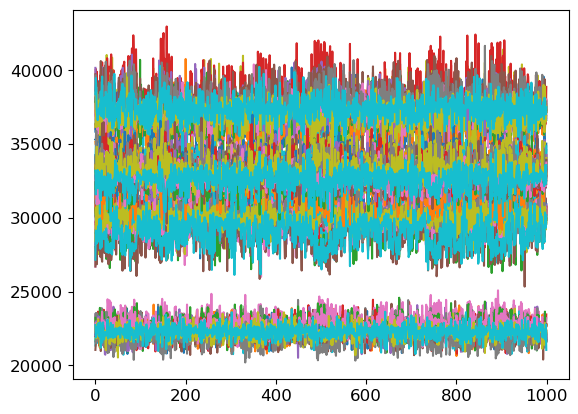

In [15]:
s = azPP.posterior.s
print(np.shape(s))
for i in range(100):
    plt.plot(s[0,:,i])

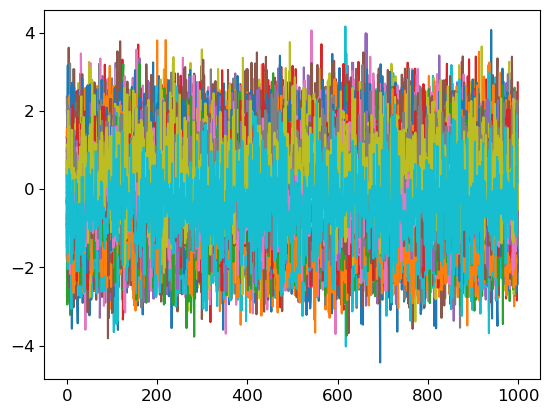

In [22]:
snorm = azPP.posterior.snorm
np.shape(snorm)
for i in range(100):
    plt.plot(snorm[0,:,i])

(array([  1.,   5.,  12.,  18.,  38.,  56.,  90.,  97., 146., 139., 119.,
         92.,  61.,  47.,  41.,  22.,   9.,   4.,   2.,   1.]),
 array([-3.23898 , -2.936855, -2.63473 , -2.332605, -2.03048 , -1.728355,
        -1.42623 , -1.124105, -0.82198 , -0.519855, -0.21773 ,  0.084395,
         0.38652 ,  0.688645,  0.99077 ,  1.292895,  1.59502 ,  1.897145,
         2.19927 ,  2.501395,  2.80352 ]),
 <BarContainer object of 20 artists>)

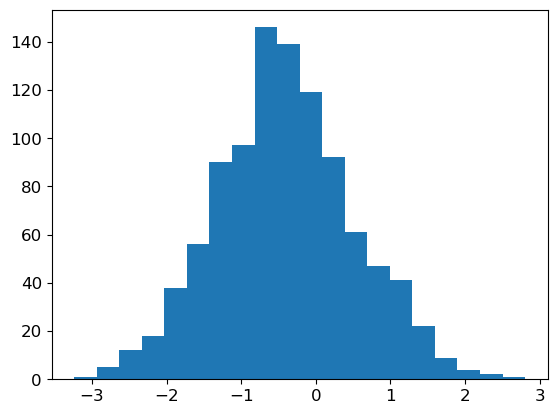

In [29]:
plt.hist(snorm[0,:,99], bins=20)

### Z-transformed model

C:\Users\mes22ss\AppData\Local\Temp\ipykernel_116820\3252463979.py:59: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(posterior_Es[j,:,k], ax=ax[2,0], hist=False, color=colors[k], kde_kws={'linestyle':linestyles[j], 'linewidth':0.75}, label=str(k+1))
c:\Users\mes22ss\AppData\Local\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
C:\Users\mes22ss\AppData\Local\Temp\ipykernel_116820\3252463979.py:61: UserWarning: 

`distplot` is a depre

81692.70038637261


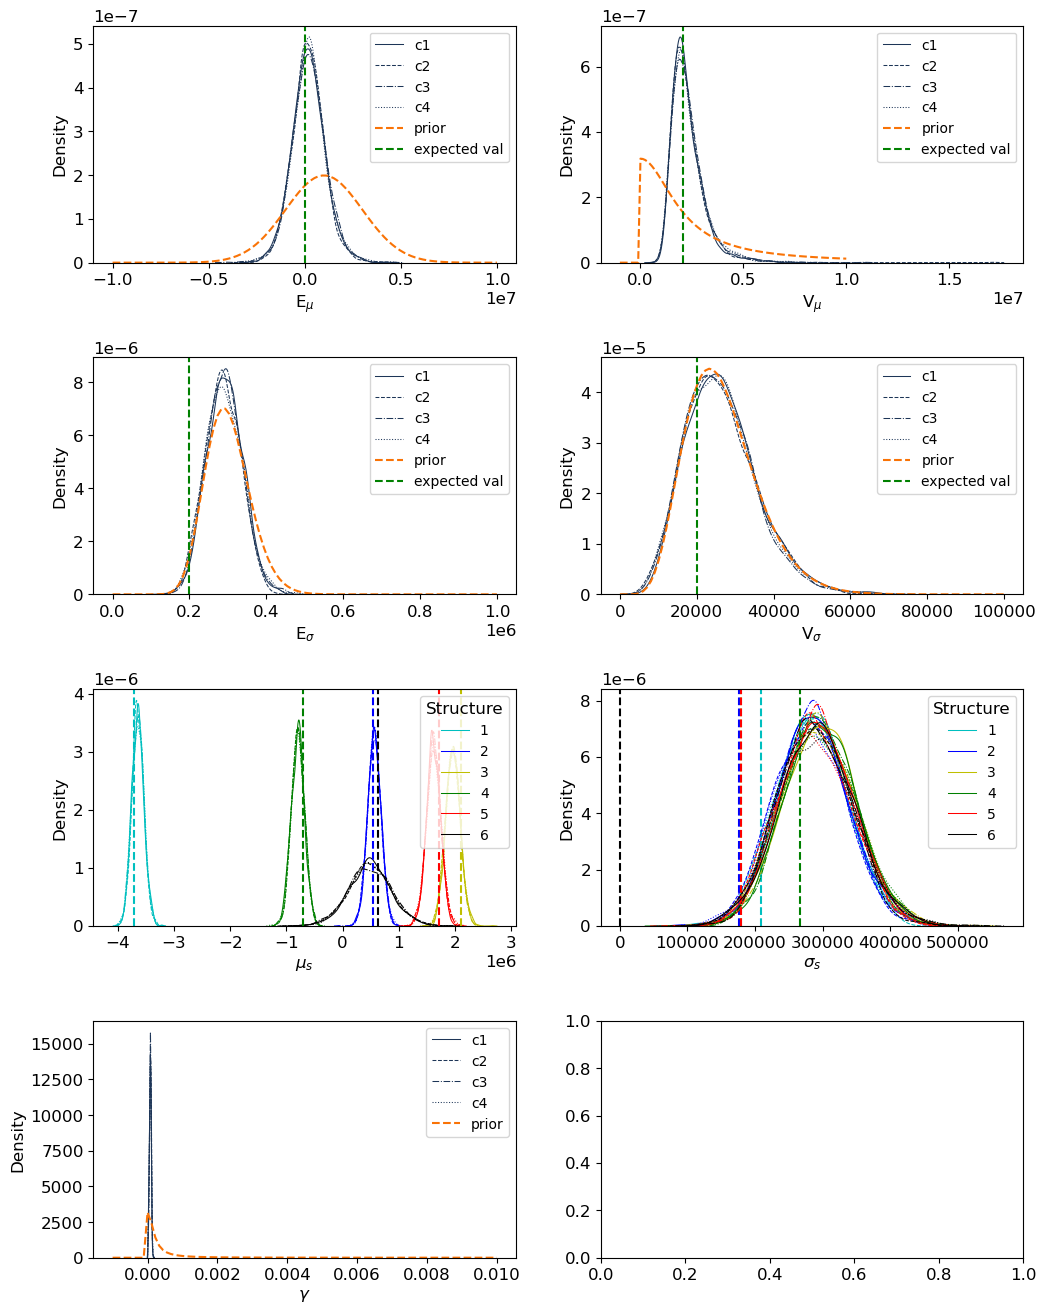

In [124]:
from scipy.stats import norm, halfcauchy
import seaborn as sns

#priors for plotting
z_Emu_x = np.linspace(-1e7, 1e7, 100)
z_Emu_y = norm.pdf(z_Emu_x, z_Emu0[0], z_Emu0[1])
z_Vmu_x = np.linspace(-1e6, 1e7, 100)
z_Vmu_y = halfcauchy.pdf(z_Vmu_x, z_Vmu0[0], z_Vmu0[1])
#z_Vmu_y = gamma.pdf(z_Vmu_x, a=z_Vmu0[0], scale=1/z_Vmu0[1])

z_Esig_x = np.linspace(0, 1e6, 100)
z_Esig_y = gamma.pdf(z_Esig_x, a=z_Esig0[0], scale=1/z_Esig0[1])
#z_Esig_y = halfcauchy.pdf(z_Esig_x, z_Esig0[0], z_Esig0[1])
z_Vsig_x = np.linspace(0, 1e5, 100)
z_Vsig_y = gamma.pdf(z_Vsig_x, a=z_Vsig0[0], scale=1/z_Vsig0[1])
#z_Vsig_y = halfcauchy.pdf(z_Vsig_x, z_Vsig0[0], z_Vsig0[1])

z_gamma_x = np.linspace(-1e-3, 1e-2, 100)
#z_gamma_y = gamma.pdf(z_gamma_x, a=z_gamma0[0], scale=1/z_gamma0[1])
z_gamma_y = halfcauchy.pdf(z_gamma_x, z_gamma0[0], z_gamma0[1])


# posteriors
posterior_Emu = azPP.posterior.Emu
posterior_Vmu = azPP.posterior.Vmu

posterior_Esig = azPP.posterior.Esig
posterior_Vsig = azPP.posterior.Vsig

posterior_Es = azPP.posterior.Es
posterior_Vs = azPP.posterior.Vs
posterior_gamma = azPP.posterior.gamma

posterior_s = azPP.posterior.s

plt.rcParams.update({'font.size': 12})

fig, ax = plt.subplots(4,2,figsize=(12,16))
fig.subplots_adjust(hspace=0.4) # adjust subplot spacing

linestyles = ['-', '--', '-.', ':']*4
colors = ["c", "b", "y", "g", "r", "k"]*16
labels = ["1", "2", "3", "4", "5"]*4

# for k in range(K):
#     for j in range(4):
#         if j == 0:
#             sns.distplot(posterior_Es[j,:,k], ax=ax[2,0], hist=False, color=colors[k], kde_kws={'linestyle':linestyles[j], 'linewidth':0.75}, label=str(k+1))
#         else:
#             sns.distplot(posterior_Es[j,:,k], ax=ax[2,0], hist=False, color=colors[k], kde_kws={'linestyle':linestyles[j], 'linewidth':0.75})
#         plt.subplot(4,2,4)

# plt.subplot(4,2,4)

for k in range(K + imb_K):
    for j in range(4):
        if j == 0:
            sns.distplot(posterior_Es[j,:,k], ax=ax[2,0], hist=False, color=colors[k], kde_kws={'linestyle':linestyles[j], 'linewidth':0.75}, label=str(k+1))
        else:
            sns.distplot(posterior_Es[j,:,k], ax=ax[2,0], hist=False, color=colors[k], kde_kws={'linestyle':linestyles[j], 'linewidth':0.75})
        plt.subplot(4,2,4)

plt.subplot(4,2,4)


for k in range(K + imb_K):
    for j in range(4):
        if j == 0:
            sns.distplot(posterior_Vs[j,:,k], ax=ax[2,1], hist=False, color=colors[k], kde_kws={'linestyle':linestyles[j], 'linewidth':0.75, 'label':str(k+1)})
        else:
            sns.distplot(posterior_Vs[j,:,k], ax=ax[2,1], hist=False, color=colors[k], kde_kws={'linestyle':linestyles[j], 'linewidth':0.75})
    plt.subplot(4,2,5)
    plt.axvline(np.mean(z_s[I==k+1]), 0,1, color=colors[k], linestyle="--")
    plt.legend(title="Structure", loc=1, fontsize=10)
    plt.subplot(4,2,6)
    plt.axvline(np.std(z_s[I==k+1]), 0,1, color=colors[k], linestyle="--")
    plt.legend(title="Structure", loc=1, fontsize=10)



for i in range(4):
    sns.distplot(posterior_Emu[i,:], ax=ax[0,0], hist=False, color="#1D3557", kde_kws={'linestyle':linestyles[i], 'linewidth':0.75}, label="c"+str(i+1))
    sns.distplot(posterior_Vmu[i,:], ax=ax[0,1], hist=False, color="#1D3557", kde_kws={'linestyle':linestyles[i], 'linewidth':0.75}, label="c"+str(i+1))
    sns.distplot(posterior_Esig[i,:], ax=ax[1,0], hist=False, color='#1D3557', kde_kws={'linestyle':linestyles[i], 'linewidth':0.75}, label="c"+str(i+1))
    sns.distplot(posterior_Vsig[i,:], ax=ax[1,1], hist=False, color='#1D3557', kde_kws={'linestyle':linestyles[i], 'linewidth':0.75}, label="c"+str(i+1))
    sns.distplot(posterior_gamma[i,:], ax=ax[3,0], hist=False, color='#1D3557', kde_kws={'linestyle':linestyles[i], 'linewidth':0.75}, label="c"+str(i+1))
   


#z_Esk = (Esk - np.mean(s))/np.std(s)

plt.subplot(4,2,1)
plt.plot(z_Emu_x, z_Emu_y, color="#F97306", linestyle="--", label="prior")
plt.axvline(np.mean(z_s), 0,1, color='g', linestyle="--", label="expected val")
plt.xlabel('E$_\mu$')
plt.legend(fontsize=10)

plt.subplot(4,2,2)
plt.plot(z_Vmu_x, z_Vmu_y, color="#F97306", linestyle="--", label="prior")
plt.axvline(np.std(z_s), 0,1, color='g', linestyle="--", label="expected val")
plt.xlabel('V$_\mu$')
plt.legend(fontsize=10)

plt.subplot(4,2,3)
plt.plot(z_Esig_x, z_Esig_y, color="#F97306", linestyle="--", label="prior")
plt.axvline(2e5, 0,1, color='g', linestyle="--", label="expected val")
plt.xlabel('E$_\sigma$')
plt.legend(fontsize=10)


stds = []
for k in range(K + imb_K):
    stds.append(np.std(z_s[I==k+1]))
stds = np.std(stds)
print(stds)


plt.subplot(4,2,4)
plt.plot(z_Vsig_x, z_Vsig_y, color="#F97306", linestyle="--", label="prior")
plt.axvline(2e4, 0,1, color='g', linestyle="--", label="expected val")
plt.xlabel('V$_\sigma$')
plt.legend(fontsize=10)


plt.subplot(4,2,5)
plt.xlabel('${\mu}_s$')

plt.subplot(4,2,6)
plt.xlabel('${\sigma}_s$')

plt.subplot(4,2,7)
plt.plot(z_gamma_x, z_gamma_y, color="#F97306", linestyle="--", label="prior")
#plt.axvline(gamma_true/np.std(wn), 0,1, color='g', linestyle="--", label="expected val")
plt.xlabel('$\gamma$')
plt.legend(fontsize=10)

plt.tight_layout;


In [79]:
divergences = ssPP.method_variables()['divergent__']

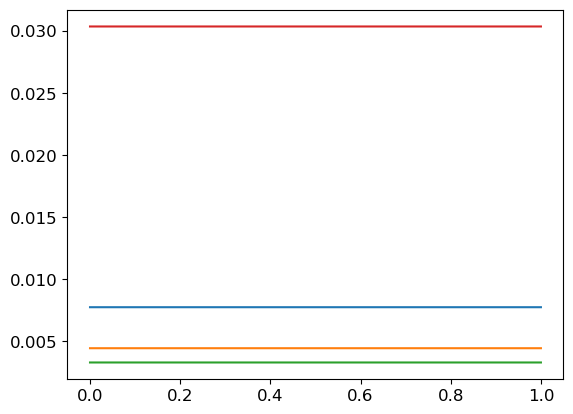

In [80]:
stepsize = ssPP.method_variables()['stepsize__']
plt.plot(np.linspace(0,1,len(stepsize)),stepsize[:,0])
plt.plot(np.linspace(0,1,len(stepsize)),stepsize[:,1])
plt.plot(np.linspace(0,1,len(stepsize)),stepsize[:,2])
plt.plot(np.linspace(0,1,len(stepsize)),stepsize[:,3])

In [81]:
ssPP.step_size

array([0.00774204, 0.0044356 , 0.00328551, 0.0303786 ])

In [82]:
prev_stepsizes = ssPP.step_size
print(prev_stepsizes)

[0.00774204 0.0044356  0.00328551 0.0303786 ]


IndexError: index 5 is out of bounds for axis 2 with size 5

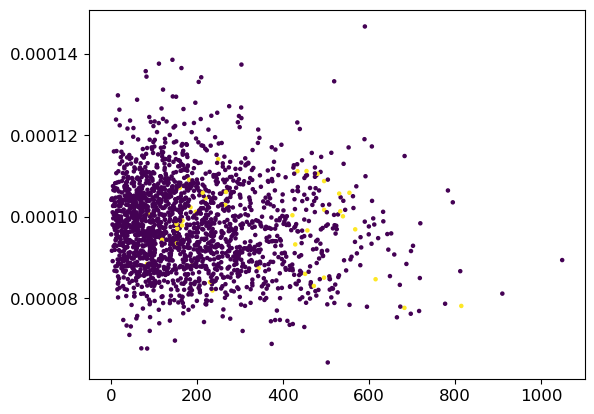

<Figure size 640x480 with 0 Axes>

In [83]:
chain = 1
col = chain - 1

# posterior_Emu
# posterior_Vmu
# posterior_Esig
# posterior_Vsig
# posterior_Es
# posterior_Vs
# posterior_gamma

#posterior_Vs[i,:,j]
plt.figure()
plt.scatter(posterior_Esig[col,:], posterior_gamma[col,:], c=divergences[:,col],s=5)
plt.figure()
plt.scatter(posterior_Esig[col,:], posterior_Vs[col,:,5], c=divergences[:,col],s=5)
#plt.ylim(0.00008,0.00015)